In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.debugger import set_trace
import random
from IPython.display import Image
import torchaudio
import librosa
import matplotlib.pyplot as plt
import librosa.display
import glob
import os.path
import IPython
import random
 

/home/kchow/.conda/envs/SpeechVAE/lib/python2.7/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
# try a dataset, save all spectrograms somewhere
filenames = glob.glob("/home/kchow/datasets/clips/*.mp3")
spectrogram_clips = []
mel_spectrogram_clips = []

restart = True

number_of_clips = 10

spec_file = 'spec_clips_sample.npy'

mel_spec_file = 'mel_spec_clips_sample.npy'

duration = 2.0
time_steps = 87

# if numpy loaded 
if not restart and os.path.isfile(spec_file) and os.path.isfile(mel_spec_file):
    spectrogram_clips = np.load(spec_file)
    mel_spectrogram_clips = np.load(mel_spec_file)
else:
    for f in filenames:
        print(f)
        y, sr = librosa.load(f, duration=duration)
        D = np.abs(librosa.stft(y))**2
        print(np.shape(D))
        D = D[:1024,:1939]
        S = librosa.feature.melspectrogram(S=D)
        S = S[:128,:1939]
        if np.shape(D)[0] != 1024 or np.shape(D)[1] != time_steps or np.shape(S)[0] != 128 or np.shape(S)[1] != time_steps:
            continue
        spectrogram_clips.append(D)
        mel_spectrogram_clips.append(S)
        if len(spectrogram_clips) == number_of_clips:
            break

np.save(spec_file, np.array(spectrogram_clips))
np.save(mel_spec_file, np.array(mel_spectrogram_clips))


/home/kchow/datasets/clips/247.mp3
(1025, 87)
/home/kchow/datasets/clips/381.mp3
(1025, 87)
/home/kchow/datasets/clips/811.mp3
(1025, 87)
/home/kchow/datasets/clips/58.mp3
(1025, 87)
/home/kchow/datasets/clips/169.mp3
(1025, 87)
/home/kchow/datasets/clips/99.mp3
(1025, 87)
/home/kchow/datasets/clips/572.mp3
(1025, 87)
/home/kchow/datasets/clips/801.mp3
(1025, 87)
/home/kchow/datasets/clips/277.mp3
(1025, 87)
/home/kchow/datasets/clips/286.mp3
(1025, 87)


In [3]:
# somethign wrong with snipping? Or when librosa loads need to change it. Or different dataset. 
snip_spectrogram_clips = mel_spectrogram_clips
np.shape(snip_spectrogram_clips)

(10, 128, 87)

In [60]:
batch_size = 10
epochs = 100
no_cuda = False
seed = 1
beta = 1
log_interval = 1000
cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
loss_function_type = 'Beta' # [DIP-VAE1, 'DIP-VAE2, Beta']
latent_dimensions = 1
fc_dimensions = 5
print(torch.cuda.current_device())
torch.cuda.set_device(0)
print(torch.cuda.current_device())

0
0


In [61]:
torch.manual_seed
device = torch.device("cuda" if cuda else "cpu")

In [62]:

#time_steps = 200
freq_filters = 128
channels = 50
k_size = 3
a = 122
b = 94 #1933
# with max pooling new dimensions 
c = 18
d = 11
class MusicSpecAEConv2D(nn.Module):
    def __init__(self):
        super(MusicSpecAEConv2D, self).__init__()
        self.conv1 = nn.Conv2d(1, channels, kernel_size=k_size)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=k_size)
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=k_size)
        
        self.maxpool1 = nn.MaxPool2d((3, 3), return_indices=True)
        self.maxpool2 = nn.MaxPool2d((2, 2), return_indices=True)
        
        # max pool
        # batch norm 
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.bn3 = nn.BatchNorm2d(channels)
        
        self.bn4 = nn.BatchNorm2d(channels)
        self.bn5 = nn.BatchNorm2d(channels)
        self.bn6 = nn.BatchNorm2d(channels)
        
        # 23 
        
        self.fc1 = nn.Linear(c*d*channels, fc_dimensions)
        self.fc2 = nn.Linear(latent_dimensions, fc_dimensions)
        self.fc3 = nn.Linear(fc_dimensions, c*d*channels)
 
        self.deconv1 = nn.ConvTranspose2d(channels, channels, kernel_size=k_size) #to get same size, just kernel+1
        self.deconv2 = nn.ConvTranspose2d(channels, channels, kernel_size=k_size)
        self.deconv3 = nn.ConvTranspose2d(channels, 1, kernel_size=k_size)
        
        self.maxunpool1 = nn.MaxUnpool2d((2, 2))
        self.maxunpool2 = nn.MaxUnpool2d((3, 3))
        
        self.indicespool1 = None
        self.indicespool2 = None
        
        self.outputsizepool1 = None
        self.outputsizepool2 = None
    
    def encode(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        self.outputsizepool1 = x.size()
        x, self.indicespool1 = self.maxpool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        self.outputsizepool2 = x.size()
        x, self.indicespool2 = self.maxpool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        #set_trace()
        x = x.view(x.size(0), -1)
        x = F.sigmoid(self.fc1(x))
        
        return x
    
    def decode(self, z):
        #set_trace()
        z = F.relu(self.fc3(z))
        z = z.view(z.size(0), channels, c, d)
        z = F.relu(self.bn4(self.deconv1(z)))
        z = self.maxunpool1(z, self.indicespool2, output_size = self.outputsizepool2)
        z = F.relu(self.bn5(self.deconv2(z)))
        # size aint right
        z = self.maxunpool2(z, self.indicespool1, output_size = self.outputsizepool1)
        z = F.sigmoid(self.deconv3(z))
        return z
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


In [63]:
model = MusicSpecAEConv2D().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.SGD(model.parameters(), lr=1e-3)
average_losses = []

def loss_function(recon_x, x):
    MSE = F.mse_loss(recon_x, x)
    return MSE 

# code from https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def data_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train(epoch):
    model.train()
    train_loss = 0
    subset_data = snip_spectrogram_clips[:10]
    random.shuffle(subset_data)
    # shuffle subset
    for data in data_batch(subset_data, batch_size):
        # update this to use a larger batch size 
        data = np.array(data)

        data = torch.from_numpy(data)
        data = data.view(data.size(0), 1, freq_filters, time_steps)
        #set_trace()
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data) #/data.size(0)
        loss.backward()
        #use clip here 
        #clip_gradient = 2
        #nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
        #set_trace()
        train_loss += loss.item()
        optimizer.step()
        print(epoch, loss.item())
    average_loss = train_loss/float(len(subset_data))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, average_loss))#len(mel_spectrogram_clips)))
    average_losses.append(average_loss)

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    

1 5781.82226562
====> Epoch: 1 Average loss: 578.1822
2 5781.70898438
====> Epoch: 2 Average loss: 578.1709
3 5781.59375
====> Epoch: 3 Average loss: 578.1594
4 5781.45556641
====> Epoch: 4 Average loss: 578.1456
5 5781.31445312
====> Epoch: 5 Average loss: 578.1314
6 5781.16259766
====> Epoch: 6 Average loss: 578.1163
7 5780.98779297
====> Epoch: 7 Average loss: 578.0988
8 5780.78125
====> Epoch: 8 Average loss: 578.0781
9 5780.55761719
====> Epoch: 9 Average loss: 578.0558
10 5780.33837891
====> Epoch: 10 Average loss: 578.0338
11 5780.109375
====> Epoch: 11 Average loss: 578.0109
12 5779.87402344
====> Epoch: 12 Average loss: 577.9874
13 5779.64990234
====> Epoch: 13 Average loss: 577.9650
14 5779.421875
====> Epoch: 14 Average loss: 577.9422
15 5779.21435547
====> Epoch: 15 Average loss: 577.9214
16 5779.00683594
====> Epoch: 16 Average loss: 577.9007
17 5778.81738281
====> Epoch: 17 Average loss: 577.8817
18 5778.65576172
====> Epoch: 18 Average loss: 577.8656
19 5778.50634766
===

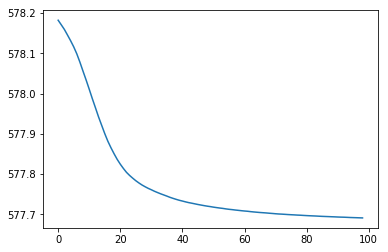

In [64]:
for epoch in range(1, 100):
    train(epoch)
plt.figure(1)
plt.plot(average_losses)
plt.show()

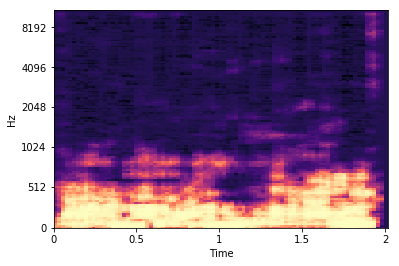

In [66]:
# AE
# reconstruct signal and see how it looks.
# out of memory gucked
with torch.no_grad():
    sample = snip_spectrogram_clips[1]
    sample = torch.from_numpy(sample)
    #sample = torch.transpose(sample, 0, 1)
    sample = sample.contiguous().view(1, 1, freq_filters, time_steps)
    sample = sample.to(device, dtype=torch.float)
    z = model.encode(sample)
    sample = model.decode(z).cpu()
    sample = sample.view(1, freq_filters, time_steps)
    librosa.display.specshow(librosa.power_to_db(sample[0], ref=np.max), y_axis='mel', x_axis='time')
#y_out = librosa.istft(sample[0].numpy(), length=110122)
#IPython.display.Audio(data=y_out, rate=22050)


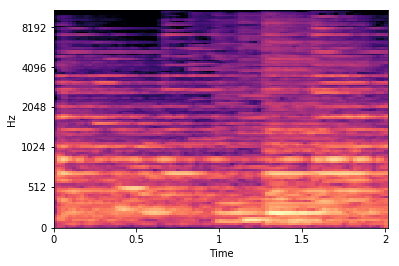

In [36]:
sample_snip = snip_spectrogram_clips[0]
librosa.display.specshow(librosa.power_to_db(sample_snip, ref=np.max), y_axis='mel', x_axis='time')
#y_out = librosa.istft(sample_snip, length=110122)
#IPython.display.Audio(data=y_out, rate=22050)

In [11]:
# getting stuck and not changing wtf. For some reason getting fucked with 100 time steps. No idea why.
sample_snip = snip_spectrogram_clips[500]
librosa.display.specshow(librosa.amplitude_to_db(sample_snip, ref=np.max), y_axis='linear', x_axis='time')
y_out = librosa.istft(sample_snip, length=50122)
IPython.display.Audio(data=y_out, rate=22050)

IndexError: list index out of range

In [ ]:
sum(spectrogram_clips[0] - spectrogram_clips[1])